In [1]:
import numpy as np
import sys, os, git, lammps_logfile
from matplotlib import pyplot as plt

In [3]:
current_path = os.getcwd()
git_repo = git.Repo(current_path, search_parent_directories=True)
git_path = git_repo.git.rev_parse("--show-toplevel")
path_in_folder = current_path[len(git_path)+1:]
level = path_in_folder.split("/")[-2]
tutorial_name = path_in_folder.split("/")[-1]
print("level:" , level, "& tutorial name:", tutorial_name)
sys.path.append(git_path + "/docs/sphinx/source/tutorials/figures/pyplot-perso/")
from functions import complete_panel, save_figure, set_boundaries, \
                      add_subplotlabels, set_boundaries
from color_series1 import colors
path_figures = current_path[len(git_path):] + '/'
data_path = git_path + "/docs/lammpstutorials-inputs/" + level + "/" + tutorial_name + "/Deform/"
print("data path: ", data_path)

level: level3 & tutorial name: reactive-silicon-dioxide
data path:  /home/simon/Git/LAMMPS/tutorials/docs/lammpstutorials-inputs/level3/reactive-silicon-dioxide/Deform/


In [4]:
def read_group(all_charge, n):
    group_charges = []
    for i_frame in all_charge:
        types = np.int32(np.array(i_frame).T[1])
        charges = np.float32(np.array(i_frame)[types==n].T[2])
        group_charges.append(charges)
    return group_charges

In [5]:
def read_charges(file, start_frame = None, end_frame = None):
    dump_file = open(file, "r")
    number_of_frame = 0
    used_frame = 0
    all_data = []
    for dump_line in dump_file:
        if len(dump_line.split())>1:
            if dump_line.split()[1]=='TIMESTEP': # new frame
                counter_of_line = 0
                number_of_frame += 1
                frame = []
                if (start_frame is not None) & (end_frame is not None):
                    if (number_of_frame>start_frame) & (number_of_frame<end_frame):
                        all_data.append(frame)
                        used_frame += 1
                elif (start_frame is not None):
                    if (number_of_frame>start_frame):
                        all_data.append(frame)
                        used_frame += 1
                elif (end_frame is not None):
                    if (number_of_frame<end_frame):
                        all_data.append(frame)   
                        used_frame += 1    
                else:
                    all_data.append(frame)     
                    used_frame += 1   
        counter_of_line += 1
        if counter_of_line > 9:
            id, type, q, _, _, _ = dump_line.split()
            frame.append([np.int32(id), np.int32(type), np.float32(q)])
    all_data.append(frame)
    print("total number of frame =",number_of_frame)
    print("number of frame used for analysis =",used_frame)
    return all_data

In [6]:
all_charge = read_charges(file= data_path + "dump.lammpstrj", start_frame = 10, end_frame = None)
qSi = read_group(all_charge, 1)
qO = read_group(all_charge, 2)

total number of frame = 301
number of frame used for analysis = 291


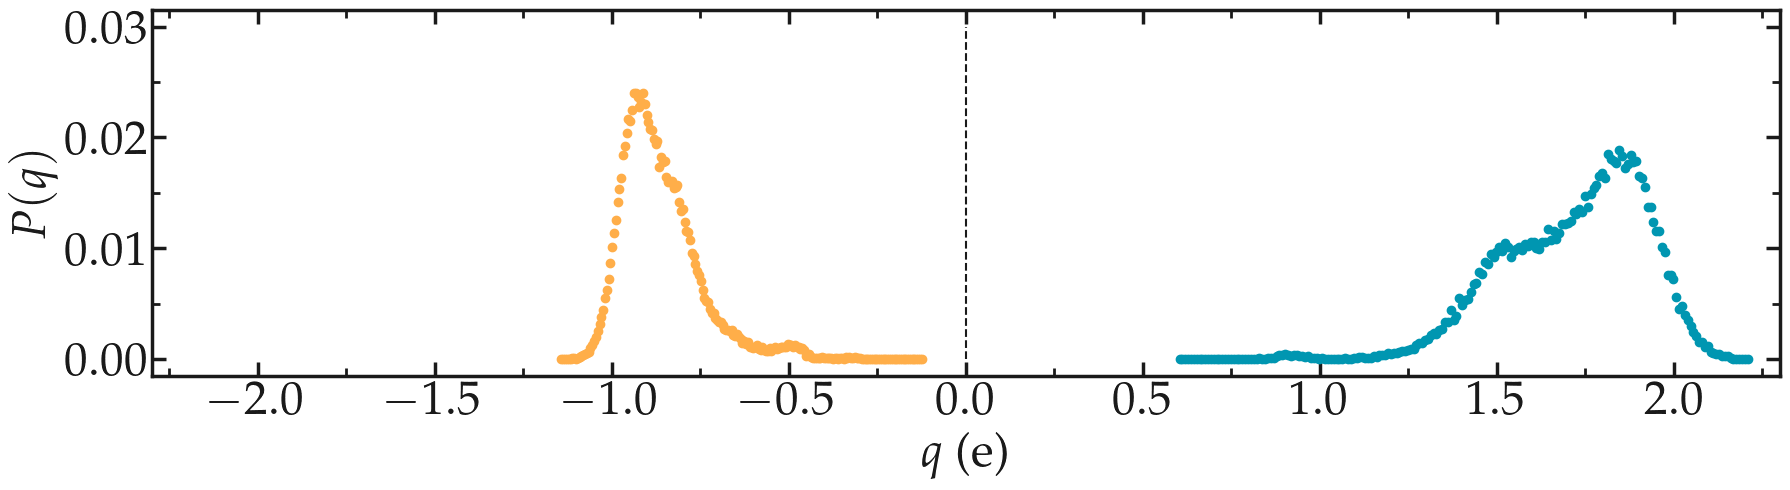

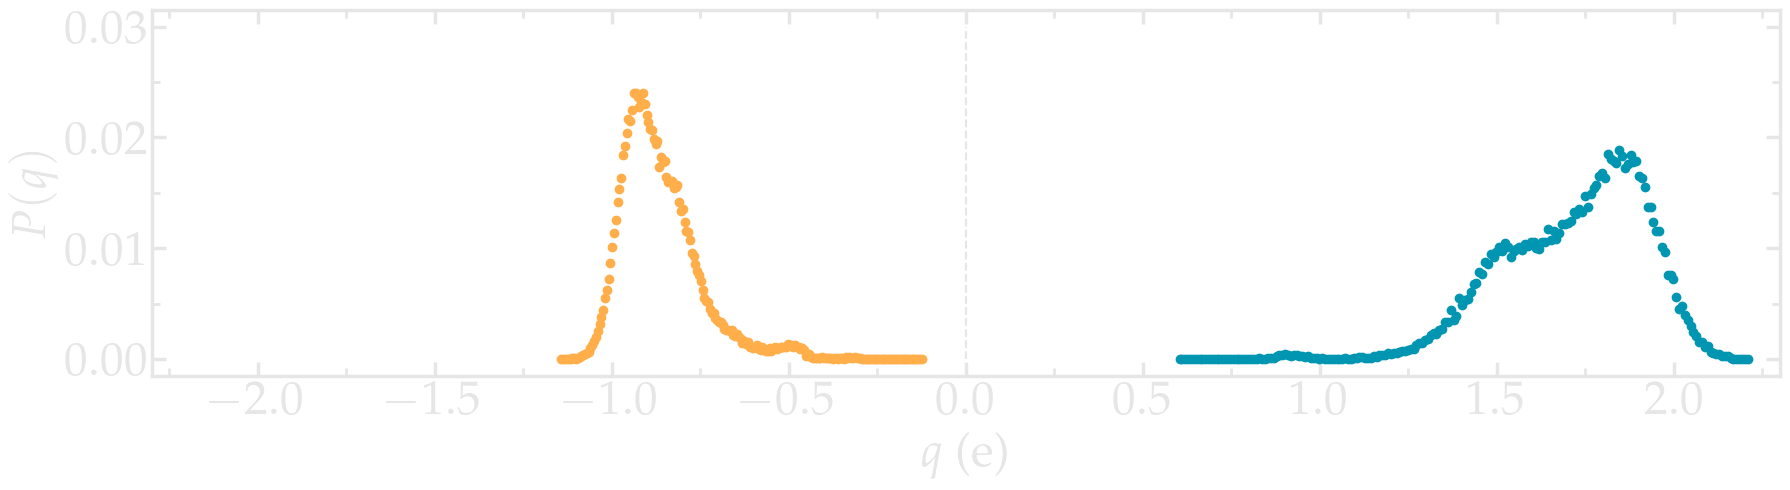

In [7]:
n_bins = 200
filename = "distribution-charge"
for mode, mygray in zip(['light', 'dark'], [colors["mylightgray"], colors["mydarkgray"]]):    
    fig = plt.figure(figsize=(18,5))
    ax, n, l_tot, c_tot = [], 0, 1, 1
    n += 1
    ax.append(plt.subplot(l_tot, c_tot, n))
    occurence, charge = np.histogram(qSi, bins=n_bins)
    charge = charge[:-1]
    ax[-1].plot(charge, occurence/np.sum(occurence), 'o', color=colors["myblue"], label="Si")
    occurence, charge = np.histogram(qO, bins=n_bins)
    charge = charge[:-1]
    ax[-1].plot(charge, occurence/np.sum(occurence), 'o', color=colors["myorange"], label="O")
    x = np.linspace(0, 0.03)
    ax[-1].plot(x*0, x, '--', color=mygray)
    complete_panel(ax[-1], r'$q$ (e)', r'$P(q)$', legend=False, axis_color=mygray)
    set_boundaries(plt, x_ticks=np.arange(-2., 2.2, 0.5), x_boundaries=(-2.3, 2.3),
                   y_ticks=np.arange(0, 0.033, 0.01))
    save_figure(plt, fig, mode, git_path, path_figures, filename)